[View in Colaboratory](https://colab.research.google.com/github/kundajelab/ssvmimp/blob/master/lsgkm.ipynb)

In [47]:
#install lsgkm
!rm -r lsgkm
! git clone https://github.com/kundajelab/lsgkm
% cd lsgkm/src
! make
! ./gkmtrain
%cd ../..

Cloning into 'lsgkm'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 198 (delta 52), reused 53 (delta 27), pack-reused 111
Receiving objects: 100% (198/198), 426.47 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (117/117), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
libsvm_gkm.c: In function ‘void kmertree_dfs_withhypexplanation(const KmerTree*, int, int, int, const BaseMismatchCountForExplanation*, int, int**, double***, int*)’:
libsvm_gkm.c:615:65: warning: ‘mmprof_mmcnt’ may be used uninitialized in this function [-Wmaybe-uninitialized]
                                     mmprof_mmcnt[data[i].seqid] += (data[i].wt*currbase_wt);
                                     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpth

In [48]:
#get the raw data
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/master/deeplift/genomics/sequences.simdata.gz


Redirecting output to ‘wget-log.1’.


In [49]:
!zcat sequences.simdata | head

seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATATAAAATAGTAGTAA

In [0]:
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "1") {print ">$F[0]\n$F[1]"}' > positives.fa
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "0") {print ">$F[0]\n$F[1]"}' > negatives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' positives.fa > test_positives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' positives.fa > train_positives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' negatives.fa > test_negatives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' negatives.fa > train_negatives.fa

In [51]:
!wc -l *.fa

   4160 kmers.fa
  12000 negatives.fa
   4000 positives.fa
   2400 test_negatives.fa
    800 test_positives.fa
   9600 train_negatives.fa
   3200 train_positives.fa
  36160 total


In [52]:
import time

t=3
c=10
g=2
l=6
k=5
d=1

!lsgkm/src/gkmtrain -t $t -c $10 -g $2 -l $l -k $k -d $d -w 3 train_positives.fa train_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3"


start = time.time()
!lsgkm/src/gkmpredict test_positives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_positives.txt
end = time.time()
print("Time taken per seq:",(end-start)/400)
start = time.time()
!lsgkm/src/gkmpredict test_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_negatives.txt
end = time.time()
print("Time taken per seq:",(end-start)/1200)

import numpy as np
from sklearn.metrics import roc_auc_score
pos_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_positives.txt")]
neg_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_negatives.txt")]
print(roc_auc_score(y_true=np.array([1 for i in range(len(pos_preds))]+[0 for i in range(len(neg_preds))]),
                    y_score=np.array(pos_preds+neg_preds)))

INFO 2018-10-08 03:24:36: Number of threads is set to 1
INFO 2018-10-08 03:24:36: Arguments:
INFO 2018-10-08 03:24:36:   posfile = train_positives.fa
INFO 2018-10-08 03:24:36:   negfile = train_negatives.fa
INFO 2018-10-08 03:24:36:   outprefix = params_t3_l6_k5_d1_g2_c10_w3
INFO 2018-10-08 03:24:36: Parameters:
INFO 2018-10-08 03:24:36:   kernel-type = 3
INFO 2018-10-08 03:24:36:   L = 6
INFO 2018-10-08 03:24:36:   k = 5
INFO 2018-10-08 03:24:36:   d = 1
INFO 2018-10-08 03:24:36:   gamma = 2
INFO 2018-10-08 03:24:36:   C = 10
INFO 2018-10-08 03:24:36:   w = 3
INFO 2018-10-08 03:24:36:   eps = 0.001
INFO 2018-10-08 03:24:36:   shrinking = no
INFO 2018-10-08 03:24:36: reading 1600 sequences from train_positives.fa
INFO 2018-10-08 03:24:36: reading... 0
INFO 2018-10-08 03:24:36: reading... 1000
INFO 2018-10-08 03:24:36: reading... done
INFO 2018-10-08 03:24:36: reading 4800 sequences from train_negatives.fa
INFO 2018-10-08 03:24:36: reading... 0
INFO 2018-10-08 03:24:36: reading... 1000


In [53]:
import time
model_file = "params_t"+str(t)+"_l"+str(l)+"_k"+str(k)+"_d"+str(d)+"_g"+str(g)+"_c"+str(c)+"_w3.model.txt"

!head $model_file

start = time.time()
!lsgkm/src/gkmexplain test_positives.fa $model_file explanation_positives.txt
end = time.time()

impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("explanation_positives.txt")
]


svm_type c_svc
kernel_type gkmrbf
L 6
k 5
d 1
gamma 2
nr_class 2
total_sv 4452
rho 2.29412
label 1 -1
INFO 2018-10-08 03:25:07: Number of threads is set to 1
INFO 2018-10-08 03:25:07: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 03:25:07: reading... 1000/4452
INFO 2018-10-08 03:25:07: reading... 2000/4452
INFO 2018-10-08 03:25:07: reading... 3000/4452
INFO 2018-10-08 03:25:07: reading... 4000/4452
INFO 2018-10-08 03:25:07: write prediction result to explanation_positives.txt
INFO 2018-10-08 03:25:18: 100 scored
INFO 2018-10-08 03:25:28: 200 scored
INFO 2018-10-08 03:25:39: 300 scored
INFO 2018-10-08 03:25:49: 400 scored


-0.6464163029000001


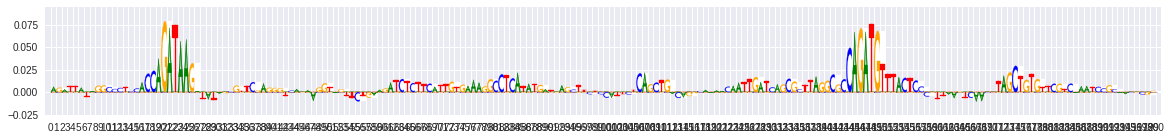

0.04206151120000001


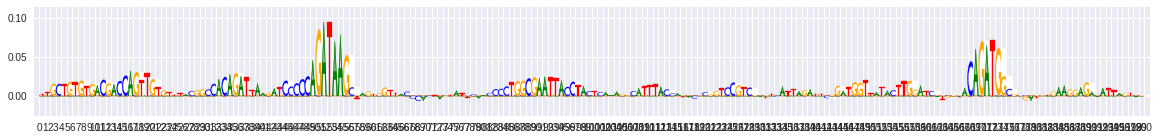

0.26993512899999983


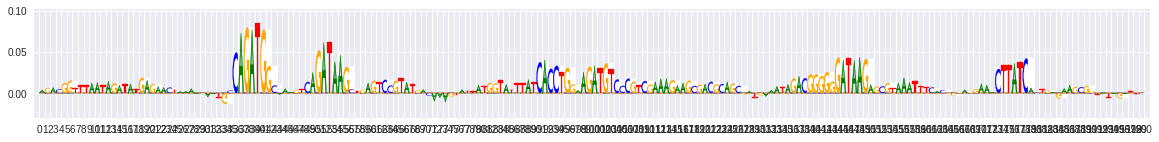

0.1731713950999998


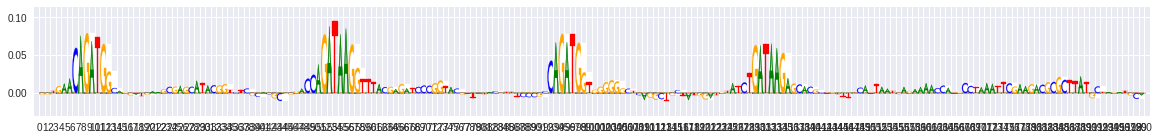

-0.6984822585000001


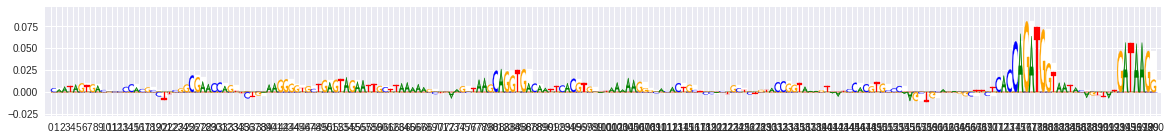

0.09106044400000002


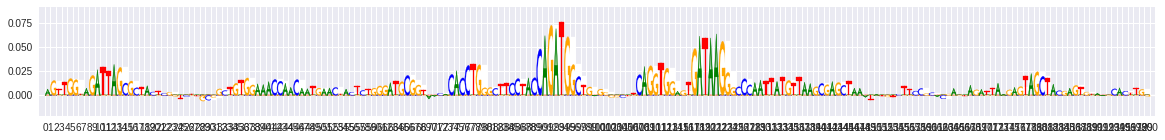

-0.08536281740000051


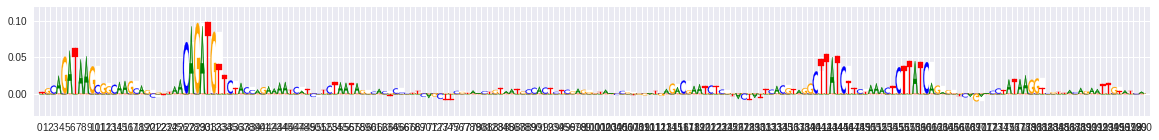

-0.5653447550000001


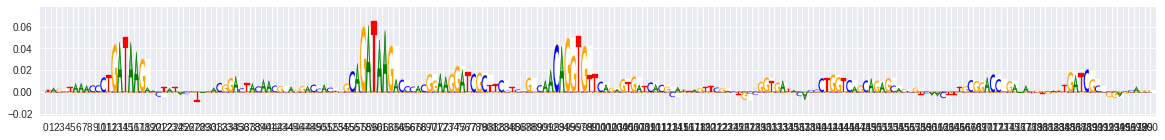

0.10903510890000012


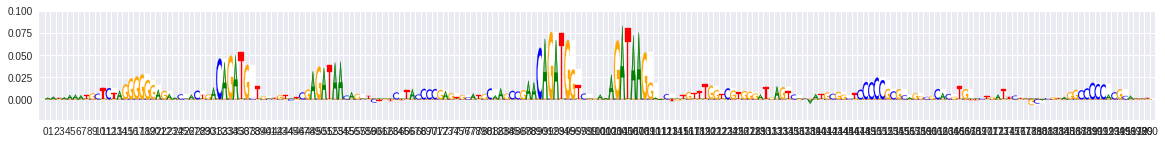

-1.3061779062000003


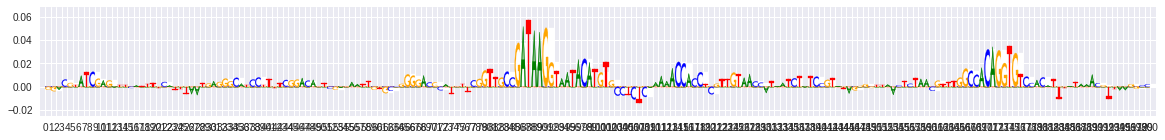

In [54]:
!pip install deeplift

from deeplift.visualization import viz_sequence
for i in range(10):
  print(np.sum(impscores[i]) - 2.53961)
  viz_sequence.plot_weights(impscores[i])


In [0]:

def run_ism(model_file_path,sequence,temp_filepath):
  
  letter_to_idx = {'A':0, 'C':1, 'G':2, 'T':3, 'N': -1}
  
  fh = open(temp_filepath,'w')
  fh.write(">orig_seq\n")
  fh.write(sequence+"\n")
  fh.close()
  explanation_file = temp_filepath+".explanation.txt"
  !lsgkm/src/gkmexplain $temp_filepath $model_file_path $explanation_file
  
  gkmexplain_impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explanation_file)
  ][0]

  
  seq_len = len(sequence)
  fh = open(temp_filepath,'w')
  mutated_seqs = []
  seq_names = []
  
  onehot_seq = np.zeros((seq_len,4))  
  for pos in range(seq_len):
    orig_letter_idx = letter_to_idx[sequence[pos]]
    if (orig_letter_idx != -1):
      onehot_seq[pos,orig_letter_idx] = 1
    for letter in ['A','C','G','T']:
      letter_idx = letter_to_idx[letter]
      fh.write(">pos-"+str(pos)+"_base-"+str(letter_idx)+"\n")
      fh.write(sequence[:pos]+letter+sequence[pos+1:]+"\n")
  fh.close()
  
  predictions_file = temp_filepath+".preds.txt"
  !lsgkm/src/gkmpredict $temp_filepath $model_file_path $predictions_file
    
  ism_importance_scores = np.zeros((seq_len,4))
  for line in open(predictions_file):
    seq_name,pred = line.rstrip().split("\t")
    pred = float(pred)
    pos,letter_idx = seq_name.split("_")
    pos = int(pos.split("-")[1])
    letter_idx = int(letter_idx.split("-")[1])
    ism_importance_scores[pos,letter_idx] = pred
  
  !rm $temp_filepath
  !rm $predictions_file
  !rm $explanation_file
  
  ism_hyp_importance_scores = ism_importance_scores-np.mean(ism_importance_scores,axis=1)[:,None]
  ism_importance_scores = ism_hyp_importance_scores*onehot_seq
  
  return ism_importance_scores, ism_hyp_importance_scores, gkmexplain_impscores
  


INFO 2018-10-08 05:01:01: Number of threads is set to 1
INFO 2018-10-08 05:01:01: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:01:01: reading... 1000/4452
INFO 2018-10-08 05:01:01: reading... 2000/4452
INFO 2018-10-08 05:01:01: reading... 3000/4452
INFO 2018-10-08 05:01:02: reading... 4000/4452
INFO 2018-10-08 05:01:02: write prediction result to tmp.explanation.txt
INFO 2018-10-08 05:01:02: 1 scored
INFO 2018-10-08 05:01:02: Number of threads is set to 1
INFO 2018-10-08 05:01:02: test log
INFO 2018-10-08 05:01:02: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:01:02: reading... 1000/4452
INFO 2018-10-08 05:01:03: reading... 2000/4452
INFO 2018-10-08 05:01:03: reading... 3000/4452
INFO 2018-10-08 05:01:03: reading... 4000/4452
INFO 2018-10-08 05:01:03: write prediction result to tmp.preds.txt
INFO 2018-10-08 05:01:03: 100 scored
INFO 2018-10-08 05:01:04: 200 scored
INFO 2018-10-08 05:01:04: 300 scored
INFO 2018-10-08 05:01:04: 400 scored
IN

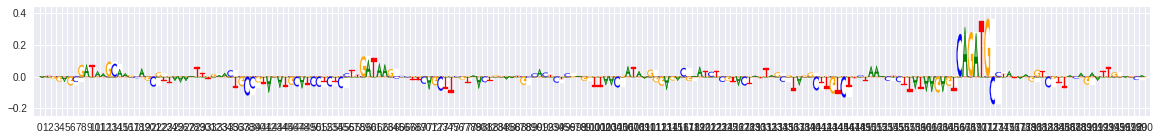

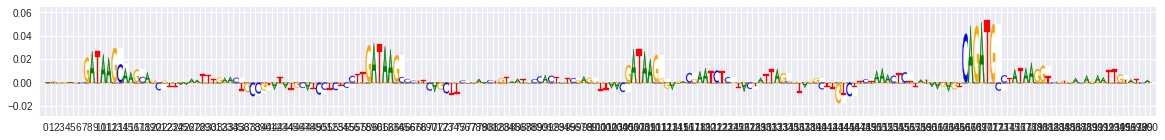

In [93]:
import time
#idx = 6
#the_seq = test_pos_seqs[idx]
the_seq = "ATGGAGCGATAAGCAAGCAGCGTTAAAATTTGAACTGCCGTATATGCATCCTCTCCTTGATAAGCCCTTCAGCTTCGTAACTGTAATGCCACTCTCGAGGTTAACGATAAGGGAGACGAATCTCGTACTATTAGCGTAGGCTTGTCTTCTAAACTCTTATAAGAGTCAGATGCCTATAAGGTCGTTACAGAATTGTATCA"


start = time.time()
ism_scores, ism_hyp_imp_scores, gkmexplain_scores = run_ism(model_file_path=model_file,
        sequence=the_seq, temp_filepath="tmp")
print(time.time()-start)

viz_sequence.plot_weights(ism_scores)
viz_sequence.plot_weights(gkmexplain_scores)

In [0]:
!python lsgkm/scripts/nrkmers.py 6 kmers.fa

In [95]:
!lsgkm/src/gkmpredict kmers.fa $model_file preds_kmers.txt

INFO 2018-10-08 05:01:43: Number of threads is set to 1
INFO 2018-10-08 05:01:43: test log
INFO 2018-10-08 05:01:43: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:01:44: reading... 1000/4452
INFO 2018-10-08 05:01:44: reading... 2000/4452
INFO 2018-10-08 05:01:44: reading... 3000/4452
INFO 2018-10-08 05:01:44: reading... 4000/4452
INFO 2018-10-08 05:01:44: write prediction result to preds_kmers.txt
INFO 2018-10-08 05:01:44: 100 scored
INFO 2018-10-08 05:01:44: 200 scored
INFO 2018-10-08 05:01:44: 300 scored
INFO 2018-10-08 05:01:44: 400 scored
INFO 2018-10-08 05:01:44: 500 scored
INFO 2018-10-08 05:01:44: 600 scored
INFO 2018-10-08 05:01:44: 700 scored
INFO 2018-10-08 05:01:44: 800 scored
INFO 2018-10-08 05:01:45: 900 scored
INFO 2018-10-08 05:01:45: 1000 scored
INFO 2018-10-08 05:01:45: 1100 scored
INFO 2018-10-08 05:01:45: 1200 scored
INFO 2018-10-08 05:01:45: 1300 scored
INFO 2018-10-08 05:01:45: 1400 scored
INFO 2018-10-08 05:01:45: 1500 scored
INFO 2018-10-08

In [0]:
deltasvm_kmer_to_pred = {}
rc_trans = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
for line in open("preds_kmers.txt"):
  kmer,pred = line.rstrip().split("\t")
  pred = float(pred)
  deltasvm_kmer_to_pred[kmer] = pred
  deltasvm_kmer_to_pred["".join([rc_trans[x] for x in kmer[::-1]])] = pred
  
def deltasvm_scores(sequence, deltasvm_kmer_to_pred, lmersize):
  
  onehot_sequence = np.zeros((len(sequence),4))
  scores = np.zeros((len(sequence),4))
  for (i,base) in enumerate(sequence):
    if (i <= len(sequence)-lmersize):
      lmer = sequence[i:i+lmersize]
      lmer_pred = deltasvm_kmer_to_pred[lmer]
      for (j,lmer_base) in enumerate(lmer):
        for base_idx,base_sub in enumerate(['A','C','G','T']):
          if base_sub!=lmer_base:
            new_lmer = lmer[:j]+base_sub+lmer[(j+1):]
            new_pred = deltasvm_kmer_to_pred[new_lmer]
            delta = new_pred - lmer_pred
            scores[i+j, base_idx] = delta
          else:
            onehot_sequence[i+j, base_idx] = 1
  scores = scores - np.mean(scores,axis=1)[:,None]
  return scores*onehot_sequence, scores
  

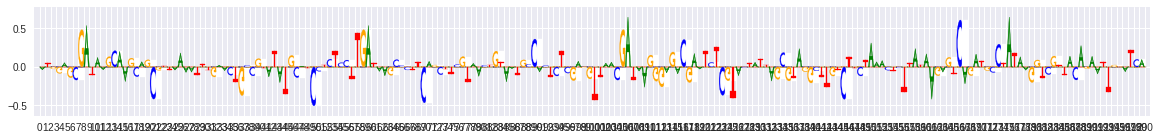

In [97]:
delta_svm_scores, delta_svm_hypscores = deltasvm_scores(the_seq, deltasvm_kmer_to_pred, 6)
viz_sequence.plot_weights(delta_svm_scores)

(200,)
200
(10, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:03:00: Number of threads is set to 1
INFO 2018-10-08 05:03:00: test log
INFO 2018-10-08 05:03:00: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:03:00: reading... 1000/4452
INFO 2018-10-08 05:03:00: reading... 2000/4452
INFO 2018-10-08 05:03:00: reading... 3000/4452
INFO 2018-10-08 05:03:01: reading... 4000/4452
INFO 2018-10-08 05:03:01: write prediction result to tmp_preds
INFO 2018-10-08 05:03:01: 10 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:03:01: Number of threads is set to 1
INFO 2018-10-08 05:03:01: test log
INFO 2018-10-08 05:03:01: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:03:02: reading... 1000/4452
INFO 2018-10-08 05:03:02: reading... 2000/4452
INFO 2018-10-08 05:03:02: reading... 3000/4452
INFO 2018-10-08 05:03:03: reading... 4000/4452
INFO 2018-10-08 05:03:03: write prediction result to tm

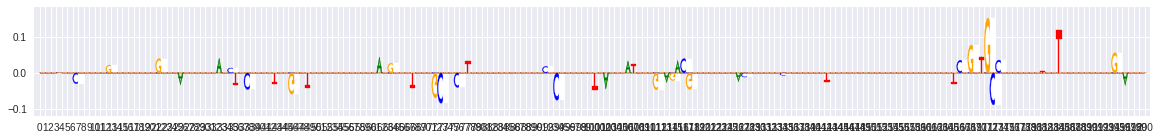

(200,)
1000
(10, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:03:15: Number of threads is set to 1
INFO 2018-10-08 05:03:15: test log
INFO 2018-10-08 05:03:15: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:03:15: reading... 1000/4452
INFO 2018-10-08 05:03:15: reading... 2000/4452
INFO 2018-10-08 05:03:16: reading... 3000/4452
INFO 2018-10-08 05:03:16: reading... 4000/4452
INFO 2018-10-08 05:03:16: write prediction result to tmp_preds
INFO 2018-10-08 05:03:16: 10 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:03:16: Number of threads is set to 1
INFO 2018-10-08 05:03:16: test log
INFO 2018-10-08 05:03:16: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:03:17: reading... 1000/4452
INFO 2018-10-08 05:03:17: reading... 2000/4452
INFO 2018-10-08 05:03:17: reading... 3000/4452
INFO 2018-10-08 05:03:17: reading... 4000/4452
INFO 2018-10-08 05:03:17: write prediction result to t

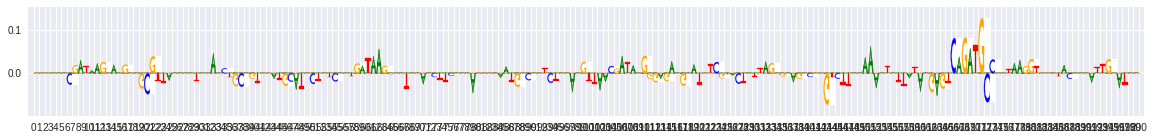

(200,)
2000
(10, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:03:49: Number of threads is set to 1
INFO 2018-10-08 05:03:49: test log
INFO 2018-10-08 05:03:49: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:03:49: reading... 1000/4452
INFO 2018-10-08 05:03:50: reading... 2000/4452
INFO 2018-10-08 05:03:50: reading... 3000/4452
INFO 2018-10-08 05:03:50: reading... 4000/4452
INFO 2018-10-08 05:03:50: write prediction result to tmp_preds
INFO 2018-10-08 05:03:50: 10 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:03:51: Number of threads is set to 1
INFO 2018-10-08 05:03:51: test log
INFO 2018-10-08 05:03:51: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:03:51: reading... 1000/4452
INFO 2018-10-08 05:03:51: reading... 2000/4452
INFO 2018-10-08 05:03:51: reading... 3000/4452
INFO 2018-10-08 05:03:52: reading... 4000/4452
INFO 2018-10-08 05:03:52: write prediction result to t

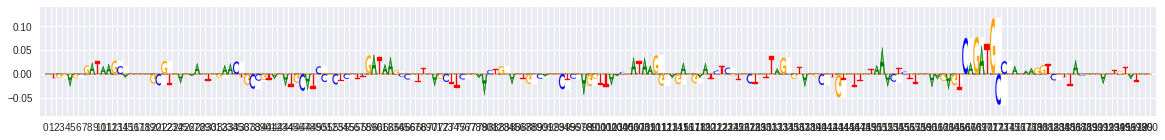

(200,)
4000
(10, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:04:53: Number of threads is set to 1
INFO 2018-10-08 05:04:53: test log
INFO 2018-10-08 05:04:53: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:04:53: reading... 1000/4452
INFO 2018-10-08 05:04:53: reading... 2000/4452
INFO 2018-10-08 05:04:53: reading... 3000/4452
INFO 2018-10-08 05:04:54: reading... 4000/4452
INFO 2018-10-08 05:04:54: write prediction result to tmp_preds
INFO 2018-10-08 05:04:54: 10 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:04:54: Number of threads is set to 1
INFO 2018-10-08 05:04:54: test log
INFO 2018-10-08 05:04:54: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:04:54: reading... 1000/4452
INFO 2018-10-08 05:04:55: reading... 2000/4452
INFO 2018-10-08 05:04:55: reading... 3000/4452
INFO 2018-10-08 05:04:55: reading... 4000/4452
INFO 2018-10-08 05:04:55: write prediction result to t

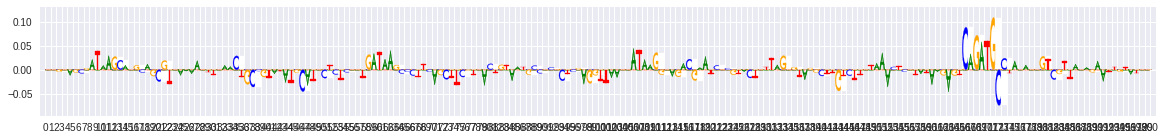

(200,)
10000
(10, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:06:41: Number of threads is set to 1
INFO 2018-10-08 05:06:41: test log
INFO 2018-10-08 05:06:41: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:06:41: reading... 1000/4452
INFO 2018-10-08 05:06:41: reading... 2000/4452
INFO 2018-10-08 05:06:41: reading... 3000/4452
INFO 2018-10-08 05:06:41: reading... 4000/4452
INFO 2018-10-08 05:06:42: write prediction result to tmp_preds
INFO 2018-10-08 05:06:42: 10 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:06:43: Number of threads is set to 1
INFO 2018-10-08 05:06:43: test log
INFO 2018-10-08 05:06:43: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:06:43: reading... 1000/4452
INFO 2018-10-08 05:06:43: reading... 2000/4452
INFO 2018-10-08 05:06:44: reading... 3000/4452
INFO 2018-10-08 05:06:44: reading... 4000/4452
INFO 2018-10-08 05:06:44: write prediction result to 

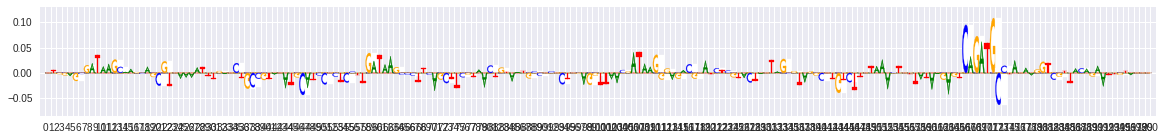

(200,)
20000
(10, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:11:41: Number of threads is set to 1
INFO 2018-10-08 05:11:41: test log
INFO 2018-10-08 05:11:41: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:11:41: reading... 1000/4452
INFO 2018-10-08 05:11:41: reading... 2000/4452
INFO 2018-10-08 05:11:42: reading... 3000/4452
INFO 2018-10-08 05:11:42: reading... 4000/4452
INFO 2018-10-08 05:11:42: write prediction result to tmp_preds
INFO 2018-10-08 05:11:42: 10 scored
(1, 200)
tmp params_t3_l6_k5_d1_g2_c10_w3.model.txt tmp_preds
INFO 2018-10-08 05:11:43: Number of threads is set to 1
INFO 2018-10-08 05:11:43: test log
INFO 2018-10-08 05:11:43: load model params_t3_l6_k5_d1_g2_c10_w3.model.txt
INFO 2018-10-08 05:11:43: reading... 1000/4452
INFO 2018-10-08 05:11:43: reading... 2000/4452
INFO 2018-10-08 05:11:43: reading... 3000/4452
INFO 2018-10-08 05:11:44: reading... 4000/4452
INFO 2018-10-08 05:11:44: write prediction result to 

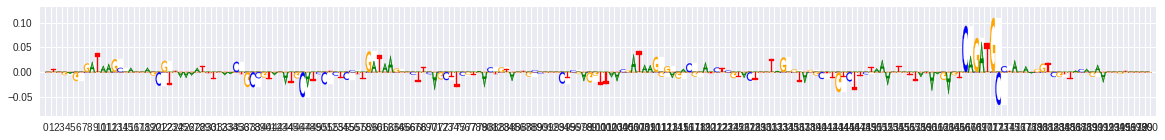

In [98]:
#!pip install shap

import shap
import numpy as np
import sys
import deeplift
from deeplift import dinuc_shuffle
import time
import random


def onehot_seq(seq):
  letter_to_index = {'A':0, 'a':0,
                     'C':1, 'c':1,
                     'G':2, 'g':2,
                     'T':3, 't':3}
  to_return = np.zeros((len(seq),4))
  for idx,letter in enumerate(seq):
    to_return[idx,letter_to_index[letter]] = 1
  return to_return


def get_shap_explanation(gkmsvm_model_path,
                         seq, background_seqs,
                         tempfile, nsamples):
  
  index_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
  letter_to_index = dict([(y,x) for (x,y) in index_to_letter.items()])
  
  def pred_func(numerically_encoded_seqs):
    print(numerically_encoded_seqs.shape)
    #convert the sequences to strings]
    seqs = ["".join(index_to_letter[x] for x in seq)
            for seq in numerically_encoded_seqs]
    
    fh = open(tempfile, "w");
    for i,seq in enumerate(seqs):
      fh.write(">seq"+str(i)+"\n")
      fh.write(seq+"\n")
    fh.close()
    
    model_preds = tempfile+"_preds"
    print(tempfile, gkmsvm_model_path, model_preds)
    
    !lsgkm/src/gkmpredict $tempfile $gkmsvm_model_path $model_preds
    
    return np.array([float(x.rstrip().split("\t")[1])
                     for x in open(model_preds)])
  
  
  X_test = np.array([letter_to_index[x] for x in seq])
  print(X_test.shape)
  print(nsamples)
  
  explainer = shap.KernelExplainer(pred_func,
                                   np.array(
                                   [[letter_to_index[x] for x in seq]
                                    for seq in background_seqs]
                                   ))
  shap_values = explainer.shap_values(X_test,
                                      nsamples=nsamples)
  return shap_values

nsamples_to_explanation = {}
nsamples_to_time_taken = {}

for nsamples_multiplier in [1,5,10,20,50,100]:

  n_bg = 10
  nsamples = len(the_seq)*nsamples_multiplier
  start = time.time()
  np.random.seed(1234)
  random.seed(1234)
  shap_explanation = get_shap_explanation(
      gkmsvm_model_path=model_file,
      seq=the_seq,
      background_seqs=[
          dinuc_shuffle.dinuc_shuffle(the_seq)
          for i in range(n_bg)],
      tempfile="tmp",
      nsamples=nsamples)
  
  time_taken = time.time() - start
  nsamples_to_time_taken[nsamples] = time_taken
  print("Time taken:",time_taken)  
  print("Num samples:",nsamples,"bg size",n_bg)
  explanation = shap_explanation[:,None]*onehot_seq(the_seq)
  nsamples_to_explanation[nsamples] = explanation
  viz_sequence.plot_weights(explanation)

200 samples time taken 11.408289909362793


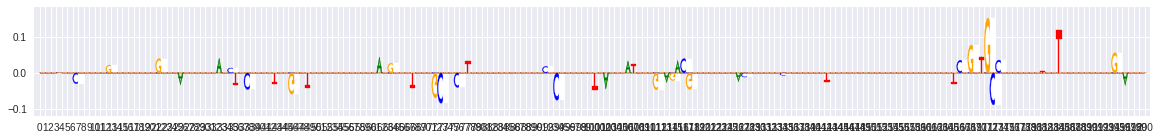

1000 samples time taken 30.171529293060303


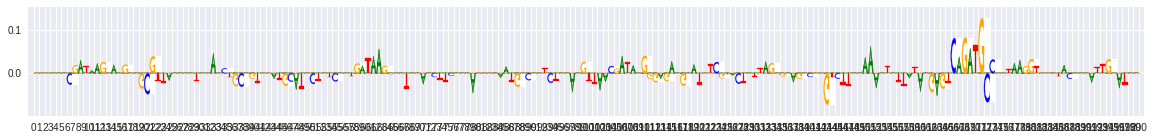

2000 samples time taken 59.43247437477112


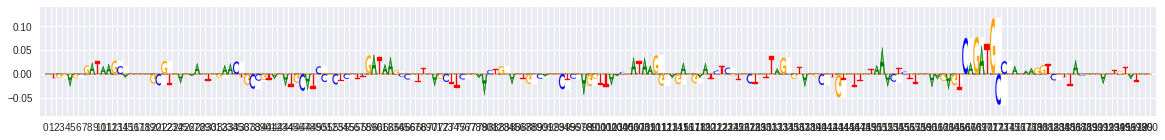

4000 samples time taken 103.72503185272217


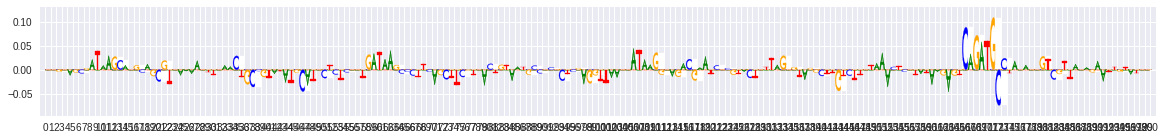

10000 samples time taken 296.0802686214447


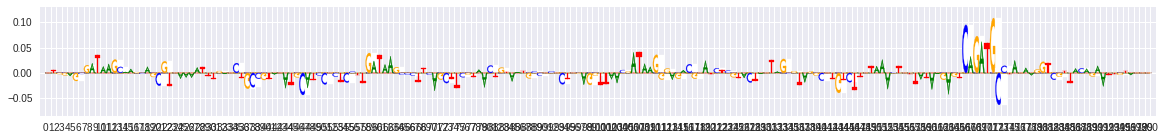

20000 samples time taken 530.8373680114746


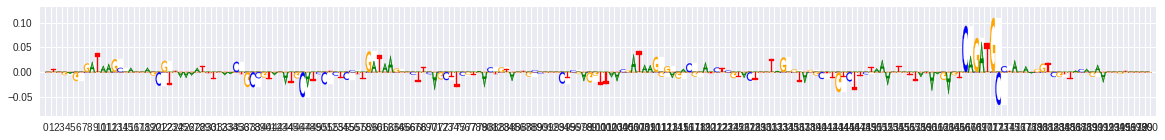

In [99]:
for nsamples in sorted(nsamples_to_explanation.keys()):
  print(nsamples,"samples","time taken",nsamples_to_time_taken[nsamples])
  viz_sequence.plot_weights(nsamples_to_explanation[nsamples])